## Loading Modules

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

import utils
from synapticTrack.io import BeamDataIOManager
from synapticTrack.visualizations import *
from synapticTrack.analysis import *

### Load Track Simulation Data

In [2]:
base_dir = 'run.00'

filename = os.path.join(base_dir, 'beam.out')
df_beam = pd.read_csv(filename, sep=r'\s+', engine='python')

filename = os.path.join(base_dir, 'step.out')
df_step = pd.read_csv(filename, sep=r'\s+', engine='python')

In [3]:
z_scanner = utils.get_z_scanner(base_dir)
print(z_scanner)

['198.12185300000002', '400.821853', '764.0236130000001', '998.7236130000001', '1076.7236130000001', '1228.323613']


### TRACK Simulation Data

In [4]:
coord_list = ['coord_wire_scanner1.out', 'coord_allison_scanner.out', 'coord_wire_scanner2.out', 'coord_wire_scanner3.out', 
              'coord_wire_scanner4.out', 'coord_ends.out']
beam_centroid = pd.DataFrame(columns=['z', 'x', 'xp', 'y', 'yp', 'dt', 'dW'])
beam_rms_size = pd.DataFrame(columns=['z', 'x', 'xp', 'y', 'yp', 'dt', 'dW'])

for i, file in enumerate(coord_list):
    filename = os.path.join(base_dir, file)

    beam_io_manager = BeamDataIOManager() 
    beam = beam_io_manager.read(code='track', filename=filename, mass_number=40, charge_state=8, beam_current=0, reference_energy=0.10)
    beam_centroid.loc[len(beam_centroid)] = beam.centroid
    beam_rms_size.loc[len(beam_rms_size)] = beam.rms_size
    beam_centroid.loc[i, 'z'] = float(z_scanner[i])*10
    beam_rms_size.loc[i, 'z'] = float(z_scanner[i])*10

# Load wire scanner offsets
ws_offset_x = np.load("ws_offset_x.npy")
ws_offset_y = np.load("ws_offset_y.npy")

beam_centroid_new = pd.DataFrame(columns=['z', 'x', 'y'])

# Apply beam centroid offsets at wire scanners
for i, ws in enumerate([0, 2, 3, 4]):
    beam_centroid_new.loc[i, 'z'] = beam_centroid.loc[ws, 'z']
    beam_centroid_new.loc[i, 'x'] = beam_centroid.loc[ws, 'x'] - ws_offset_x[i]
    beam_centroid_new.loc[i, 'y'] = beam_centroid.loc[ws, 'y'] - ws_offset_y[i]

print('beam centroid')
print(beam_centroid)

print('beam centroid_new')
print(beam_centroid_new)

print('beam rms size')
print(beam_rms_size)

beam centroid
             z         x        xp             y            yp        dt  \
0   1981.21853  0.042380  0.007714  8.159434e-07 -1.202868e-05  0.164680   
1   4008.21853 -0.026386 -0.049286 -7.519338e-07 -2.115588e-08  0.216740   
2   7640.23613  0.096338 -0.018800  5.703666e-04 -7.388111e-04  0.381971   
3   9987.23613 -0.115520 -0.138015 -3.585141e-04  1.720532e-04  0.440710   
4  10767.23613 -0.227752 -0.121982 -2.041010e-04  1.829458e-04  0.460231   
5  12283.23613 -0.010942  0.626751  5.167161e-05  1.655716e-04  0.475734   

             dW  
0 -3.625185e-10  
1 -5.706272e-07  
2 -2.934567e-07  
3 -2.607751e-07  
4 -2.484277e-07  
5  7.306254e-06  
beam centroid_new
             z         x         y
0   1981.21853  0.309014  1.061689
1   7640.23613 -0.982456  0.379088
2   9987.23613  0.729831  0.585486
3  10767.23613  0.029857 -2.737537
beam rms size
             z         x         xp         y         yp        dt        dW
0   1981.21853  3.763535   7.088097  3.8224

### Scanner Measurement Data

In [5]:
wire_base_dir = '../examples/data/scanner/2_exp_LEBT_WS'
allison_base_dir = '../examples/data/scanner/3_exp_Allison'
scanner_file_list = ['ECR32-WS001-100717.txt', ['101614_X.txt', '102829_Y.txt'], 
                     'LEBT-WS002-100523.txt', 'LEBT-WS003-100325.txt', 'LEBT-WS004-100044.txt']

skip_as = True
scanner_centroid = pd.DataFrame(columns=['z', 'x', 'y', 'x_fit', 'y_fit'])
scanner_rms_size = pd.DataFrame(columns=['z', 'x', 'y'])

for i, scanner_file in enumerate(scanner_file_list):
    beam_io_manager = BeamDataIOManager() 
    if i == 1:
        filename0 = os.path.join(allison_base_dir, scanner_file[0])
        beamas0 = beam_io_manager.read_scanner(scanner='allison', filename=filename0)
        AS0 = analyze_allison_scanner_2d(beamas0, plot=False)
        scanner_centroid.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_centroid.loc[i, 'x'] = AS0['x_center']
        scanner_centroid.loc[i, 'x_fit'] = AS0['gaussian_fit_x_center']
        scanner_rms_size.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_rms_size.loc[i, 'x'] = AS0['sigma_x']

        filename1 = os.path.join(allison_base_dir, scanner_file[1])
        beamas1 = beam_io_manager.read_scanner(scanner='allison', filename=filename1)
        AS1 = analyze_allison_scanner_2d(beamas1, plot=False)
        scanner_centroid.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_centroid.loc[i, 'y'] = AS1['x_center']
        scanner_centroid.loc[i, 'y_fit'] = AS1['gaussian_fit_x_center']
        scanner_rms_size.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_rms_size.loc[i, 'y'] = AS1['sigma_x']
    else:
        filename = os.path.join(wire_base_dir, scanner_file)
        beamws = beam_io_manager.read_scanner(scanner='wire', filename=filename)
        WS = analyze_wire_scanner(beamws, plot=False)
        scanner_centroid.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_centroid.loc[i, 'x'] = WS['x_center']
        scanner_centroid.loc[i, 'y'] = WS['y_center']
        scanner_centroid.loc[i, 'x_fit'] = WS['gaussian_fit_x_center']
        scanner_centroid.loc[i, 'y_fit'] = WS['gaussian_fit_y_center']
        scanner_rms_size.loc[i, 'z'] = float(z_scanner[i])*10
        scanner_rms_size.loc[i, 'x'] = WS['sigma_x']
        scanner_rms_size.loc[i, 'y'] = WS['sigma_y']
print("scanner centroid")
print(scanner_centroid)
print("scanner rms size")
print(scanner_rms_size)

scanner centroid
             z         x         y     x_fit     y_fit
0   1981.21853  0.309014  1.061689 -0.897645  1.270479
1   4008.21853  2.855347 -2.188706  6.799754 -4.887278
2   7640.23613 -0.982456  0.379088 -0.700186  0.358595
3   9987.23613  0.729831  0.585486  0.006707  0.696953
4  10767.23613  0.029857 -2.737537 -0.603974 -2.260032
scanner rms size
             z         x         y
0   1981.21853  3.200506  2.929691
1   4008.21853  5.639153  4.365136
2   7640.23613  2.590806   4.68213
3   9987.23613  3.995972  2.506243
4  10767.23613  6.433066  5.053004


### Beam Centroid Plot

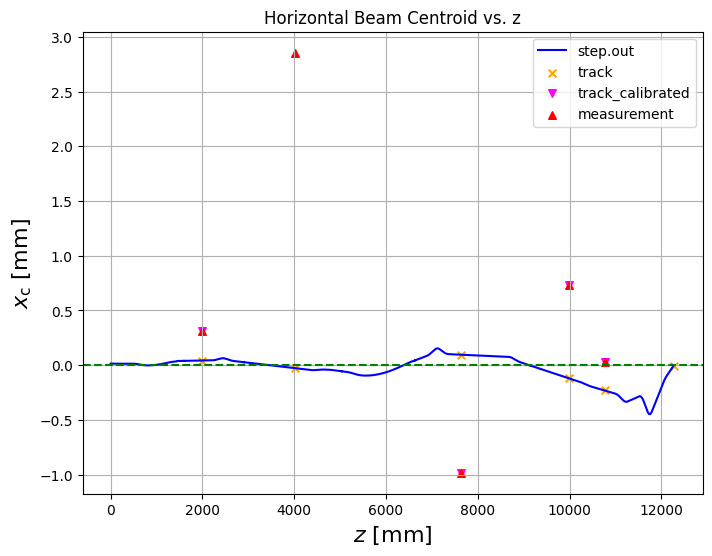

In [6]:
plt.figure(figsize=(8, 6))
plt.title("Horizontal Beam Centroid vs. z")
#plt.plot(df_beam['dist[m]']*1e3, df_beam['Xc[cm]']*10, c='k', label='beam.out')
plt.plot(df_step['z[cm]']*10, df_step['X-avg[cm]']*10, c='b', label='step.out')
plt.scatter(beam_centroid['z'], beam_centroid['x'], c='orange', label='track', marker='x', s=30)
plt.scatter(beam_centroid_new['z'], beam_centroid_new['x'], c='magenta', label='track_calibrated', marker='v', s=30)
plt.scatter(scanner_centroid['z'], scanner_centroid['x'], c='r', label='measurement', marker='^', s=30)
#plt.scatter(scanner_centroid['z'], scanner_centroid['x_fit'], c='g', label='measurement_fit', marker='o')
plt.axhline(y=0.0, c='g', ls='--')
plt.xlabel(r"$z$ [mm]", fontsize=16)
plt.ylabel(r"$x_\text{c}$ [mm]", fontsize=16)
plt.legend(loc='best')
plt.grid()

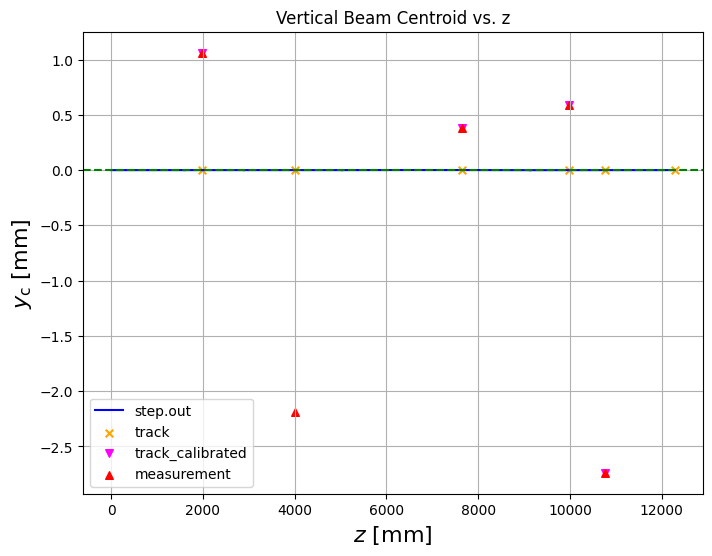

In [7]:
plt.figure(figsize=(8, 6))
plt.title("Vertical Beam Centroid vs. z")
#plt.plot(df_beam['dist[m]']*1e3, df_beam['Yc[cm]']*10, c='k', label='beam.out')
plt.plot(df_step['z[cm]']*10, df_step['Y-avg[cm]']*10, c='b', label='step.out')
plt.scatter(beam_centroid['z'], beam_centroid['y'], c='orange', label='track', marker='x', s=30)
plt.scatter(beam_centroid_new['z'], beam_centroid_new['y'], c='magenta', label='track_calibrated', marker='v', s=30)
plt.scatter(scanner_centroid['z'], scanner_centroid['y'], c='r', label='measurement', marker='^', s=30)
#plt.scatter(scanner_centroid['z'], scanner_centroid['y_fit'], c='g', label='measurement_fit', marker='o')
plt.axhline(y=0.0, c='g', ls='--')
plt.xlabel(r"$z$ [mm]", fontsize=16)
plt.ylabel(r"$y_\text{c}$ [mm]", fontsize=16)
plt.legend(loc='best')
plt.grid()

### Beam RMS Size Plot

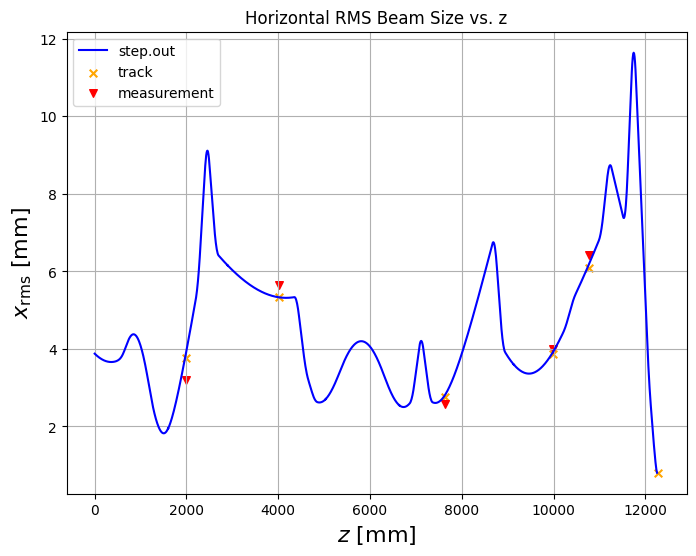

In [8]:
plt.figure(figsize=(8, 6))
plt.title("Horizontal RMS Beam Size vs. z")
#plt.plot(df_beam['dist[m]']*1e3, df_beam['x_rms[cm]']*10, c='k', label='beam.out')
plt.plot(df_step['z[cm]']*10, df_step['X-rms[cm]']*10, c='b', label='step.out')
plt.scatter(beam_rms_size['z'], beam_rms_size['x'], c='orange', label='track', marker='x', s=30)
plt.scatter(scanner_rms_size['z'], scanner_rms_size['x'], c='r', label='measurement', marker='v', s=30)
plt.xlabel(r"$z$ [mm]", fontsize=16)
plt.ylabel(r"$x_{\text{rms}}$ [mm]", fontsize=16)
plt.legend(loc='best')
plt.grid()

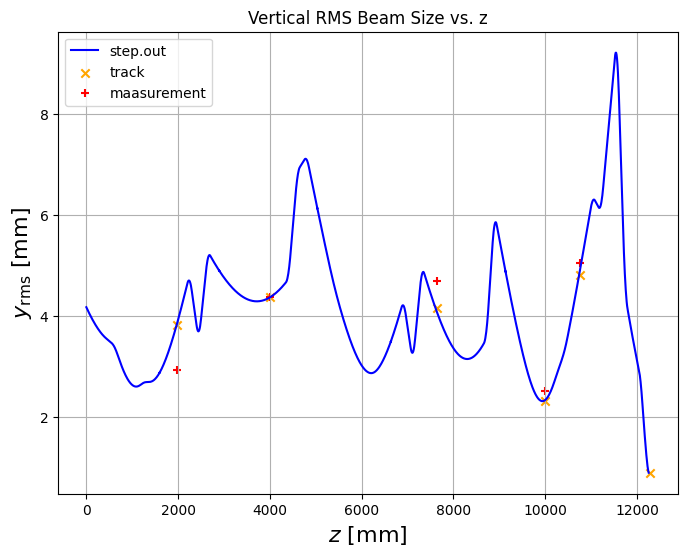

In [9]:
plt.figure(figsize=(8, 6))
plt.title("Vertical RMS Beam Size vs. z")
#plt.plot(df_beam['dist[m]']*1e3, df_beam['y_rms[cm]']*10, c='k', label='beam.out')
plt.plot(df_step['z[cm]']*10, df_step['Y-rms[cm]']*10, c='b', label='step.out')
plt.scatter(beam_rms_size['z'], beam_rms_size['y'], c='orange', label='track', marker='x')
plt.scatter(scanner_rms_size['z'], scanner_rms_size['y'], c='r', label='maasurement', marker='+')
plt.xlabel(r"$z$ [mm]", fontsize=16)
plt.ylabel(r"$y_{\text{rms}}$ [mm]", fontsize=16)
plt.legend(loc='best')
plt.grid()